# 📝 Hugging Face 기반 문서 요약 모델 구현 (News 데이터 선택)

Hugging Face Transformers를 사용해 한국어 문서 요약 모델을 구현하는 미션입니다.  
데이터 로드 → 전처리 → 토크나이징 → 파인튜닝/요약 생성 → 평가(ROUGE)까지 전체 파이프라인을 구성하는 것이 목표입니다.

---

## 내가 선택한 데이터: News만 사용한 이유

원본 데이터는 `사설(editorial)`, `법률(law)`, `뉴스(news)` 3종류가 있지만, 이번 실험에서는 뉴스만 선택했습니다.

- 뉴스는 문장 구조가 비교적 정돈되어 있고,  
  요약(요약문)도 “기사 핵심” 형태로 잘 제공되는 편이라 모델 실험 흐름을 만들기 좋습니다.
- 한 종류(news)만 고르면 데이터 분포가 단순해져서,
  전처리/토크나이징/평가 파이프라인을 깔끔하게 검증할 수 있습니다.  
  
---

## 데이터 규모

- train: 243,983
- valid: 30,122

---

## EDA로 확인한 핵심 포인트 (학습 전에 꼭 보는 이유)

학습 전에 데이터의 길이를 확인했습니다.  
왜냐면 요약 모델은 보통 입력 토큰 길이에 제한이 있고(예: 512),
길이가 긴 문서는 잘려서 정보 손실이 생길 수 있기 때문입니다.

(News train 기준)
- 원문(text) 평균 길이: 약 1,005자
- 요약(summary) 평균 길이: 약 128자
- 원문 최대 길이: 14,791자 (초장문 outlier 존재)

이 말은:
- 대부분은 무난하지만,
- 일부 초장문은 토크나이저 max_length에서 잘리면서 성능/품질에 영향을 줄 수 있습니다.

---

## 전체 워크플로우

1) JSON 로드 (뉴스 문서만 선택)  
2) 전처리 (불필요 공백/기호 정리)  
3) 토크나이징 (원문/요약 인코딩)  
4) 모델 실행 (요약 생성 또는 파인튜닝)  
5) 평가 (ROUGE, 샘플 요약 결과 확인)



◻️ 라이브러리 설치 & 임포트 & 시드고정

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip -q install transformers datasets torch rouge-score sentencepiece
!pip -q install matplotlib seaborn

import os
import json
import re
import random
import numpy as np
import pandas as pd

import torch
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import Dataset, DatasetDict
from transformers import (
    BartTokenizerFast,
    BartForConditionalGeneration,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer
)

from rouge_score import rouge_scorer

'''
시드 고정 함수
난수(랜덤)가 들어가면 실행할 때마다 결과가 달라질 수 있음
실험 비교(실험1 vs 실험2)를 하려면 결과가 "재현"되어야 해서 시드를 고정
'''
def seed_everything(seed: int = 42):
    random.seed(seed)                 # 파이썬 기본 random
    np.random.seed(seed)              # numpy random
    torch.manual_seed(seed)           # torch CPU
    torch.cuda.manual_seed_all(seed)  # torch GPU (가능한 경우)

seed_everything(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)


  Preparing metadata (setup.py) ... done
device: cuda


◻️ 폰트 설치

In [3]:
# 폰트 캐시 제거 (필수)
!rm -rf ~/.cache/matplotlib

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings(action='ignore')

# 폰트 파일 경로 (Google Drive/MyDrive/fonts/BMHANNAPro.ttf)
path = '/content/drive/MyDrive/fonts/BMHANNAPro.ttf'

# 폰트 이름 지정
# 파일 이름은 BMHANNAPro이지만, Matplotlib에서 인식할 이름은 보통 'BM HANNA Pro'입니다.
font_name = 'BM HANNA Pro'

# Matplotlib에 폰트 등록
fm.fontManager.addfont(path)

# Matplotlib 기본 폰트 설정
plt.rc('font', family=font_name)

print(f"✅ Matplotlib 폰트가 '{font_name}'로 설정되었습니다.")

✅ Matplotlib 폰트가 'BM HANNA Pro'로 설정되었습니다.


◻️ 텍스트 정제 함수
- 텍스트 정제(cleaning)는 "데이터 품질"을 올리는 가장 쉬운 방법 중 하나인데, 학습 데이터에 이상한 문자, 과한 공백, HTML 엔티티 등이 섞여 있으면 모델이 쓸데없는 패턴을 배우게 됨

In [4]:
def clean_text(text: str) -> str:

    if not isinstance(text, str):   # 가끔 None이나 숫자가 들어오면 .strip() 같은 문자열 메서드가 터집니다.
        return ""

    text = text.replace("\u200b", " ")  # zero-width space 제거

    # 기자/지역 표기 패턴이 앞에 붙는 경우가 있어 제거 (데이터에 따라 없을 수도 있음)
    text = re.sub(r"\[.*?기자.*?\]", " ", text)

    # 과도한 공백/줄바꿈 정리
    text = re.sub(r"\s+", " ", text).strip()

    # 반복 구두점 줄이기 (!!! -> !!)
    text = re.sub(r"([!?.])\1{2,}", r"\1\1", text)

    return text


◻️ JSON 로더
- 데이터셋 구조 맞추기
- 데이터가 data["documents"] 안에 문서들이 있고, 각 문서의 doc["text"]가 "중첩 리스트"로 되어 있으며 item["sentence"]를 꺼내 이어붙여야 함
- 모델은 "하나의 긴 문자열(text)"을 입력으로 받기 때문에, sentence들을 join해서 full text로 만들어주는 전처리가 필요


In [5]:
def load_json_dataset(file_path: str, category: str) -> list:
    """
    하나의 JSON 파일에서 (text, summary, category) 레코드 리스트를 만듭니다.
    반환 형태: [{"text":..., "summary":..., "category":...}, ...]
    """
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    examples = []

    for doc in data.get("documents", []):
        sentences = []

        # doc["text"]가 중첩 리스트라서 2중 for문을 사용
        # 구조가 [[{sentence...},{...}], [{...}]] 이런 식이라, 바깥/안쪽을 모두 순회해야 모든 문장을 모을 수 있습니다.
        for sublist in doc.get("text", []):
            for item in sublist:
                sentences.append(item.get("sentence", ""))

        full_text = " ".join(sentences)
        summary = doc.get("abstractive", [""])[0]  # 보통 첫 번째 요약 사용

        # 최소 정제 적용
        full_text = clean_text(full_text)
        summary = clean_text(summary)

        examples.append({
            "text": full_text,
            "summary": summary,
            "category": category
        })

    return examples


◻️ 데이터 로드

In [6]:
BASE_PATH = "/content/drive/MyDrive/정연경 강사/summarization"

train_files = {
    #"editorial": "train_original_editorial.json",
    #"law": "train_original_law.json",
    "news": "train_original_news.json",
}

valid_files = {
    #"editorial": "valid_original_editorial.json",
    #"law": "valid_original_law.json",
    "news": "valid_original_news.json",
}

train_examples = []
valid_examples = []

for cat, fname in train_files.items():
    path = os.path.join(BASE_PATH, fname)
    train_examples += load_json_dataset(path, category=cat)

for cat, fname in valid_files.items():
    path = os.path.join(BASE_PATH, fname)
    valid_examples += load_json_dataset(path, category=cat)

print("train:", len(train_examples), "valid:", len(valid_examples))


train: 243983 valid: 30122


◻️ EDA
- 카테고리 분포 + 길이

,text,summary,category
0,ha당 조사료 400만원…작물별 차등 지원 이성훈 sinawi@hanmail.net...,전라남도가 쌀 과잉문제를 근본적으로 해결하기 위해 올해부터 벼를 심었던 논에 벼 대...,news
1,"8억 투입, 고소천사벽화·자산마을에 색채 입혀 이성훈 sinawi@hanmail.n...",여수시는 컬러빌리지 사업에 8억원을 투입하여 ‘색채와 빛’ 도시를 완성하여 고소천사...,news
2,전남드래곤즈 해맞이 다짐…선수 영입 활발 이성훈 sinawi@hanmail.net ...,전남드래곤즈 임직원과 선수단이 4일 구봉산 정상에 올라 일출을 보며 2018년 구단...,news
3,"11~24일, 매실·감·참다래 등 지역특화작목 이성훈 sinawi@hanmail.n...","광양시는 농업인들의 경쟁력을 높이고, 소득안정을 위해 매실·감·참다래 등 지역특화작...",news
4,"홍콩 크루즈선사‘아쿠아리우스’ 4, 6월 여수항 입항 이성훈 sinawi@hanma...",올해 4월과 6월 두 차례에 걸쳐 타이완의 크루즈 관광객 4000여명이 여수에 입항...,news



[카테고리 분포 - train]
category
news    243983
Name: count, dtype: int64

[길이 통계 - train]
            text_len    summary_len
count  243983.000000  243983.000000
mean     1005.447183     128.450072
std       294.399053      35.880179
min         0.000000       0.000000
25%       770.000000     103.000000
50%       932.000000     125.000000
75%      1178.000000     150.000000
max     14791.000000     715.000000


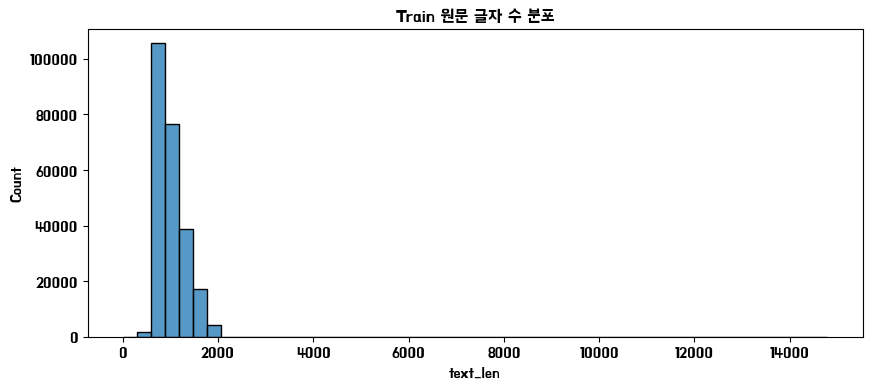

In [7]:
train_df = pd.DataFrame(train_examples)
valid_df = pd.DataFrame(valid_examples)

display(train_df.head())

print("\n[카테고리 분포 - train]")
print(train_df["category"].value_counts())

# 글자 수 분포 (토큰이 아니라 "대략적인 길이 감각" 보는 용도)
train_df["text_len"] = train_df["text"].apply(len)
train_df["summary_len"] = train_df["summary"].apply(len)

print("\n[길이 통계 - train]")
print(train_df[["text_len", "summary_len"]].describe())

plt.figure(figsize=(10, 4))
sns.histplot(train_df["text_len"], bins=50)
plt.title("Train 원문 글자 수 분포")
plt.show()


🟩 실험 설계

- 입력 길이 제한(512 토큰)을 어떻게 다루는지에 따라 성능이 달라질 수 있습니다.
    - 실험 1: Standard Truncation   
  토크나이저에서 `truncation=True, max_length=512`로 앞부분부터 자릅니다.
    - 실험 2: Head-Tail Strategy  
  문서가 너무 길면 "앞부분(head)"과 "뒷부분(tail)"을 나눠 가져와서  
  뒤쪽에 중요한 정보(결론/결과)가 있는 경우를 커버하려고 시도합니다.

데이터가 뉴스처럼 두괄식이면 실험 1이 강할 수 있고,
법률/사설처럼 뒤에 결론이 몰리면 실험 2가 이득일 수 있습니다.

◻️ HF 데이터셋 변환 + 실험1 토크나이징

In [8]:
# Hugging Face Trainer는 HF Dataset 형태를 좋아함
# map/batched 같은 기능으로 전처리와 토크나이징을 빠르게 적용할 수 있음

dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df[["text", "summary", "category"]]),
    "validation": Dataset.from_pandas(valid_df[["text", "summary", "category"]]),
})

MODEL_NAME = "gogamza/kobart-base-v1"
tokenizer = BartTokenizerFast.from_pretrained(MODEL_NAME)

# (실험1) Standard truncation
def tokenize_standard(batch):
    # batch는 dict 형태이며, batched=True면 "리스트 단위"로 들어옵니다.
    # 예: batch["text"] = [문장1, 문장2, ...]
    model_inputs = tokenizer(
        batch["text"],
        max_length=512,
        truncation=True
    )

    # text_target은 요약(summary)을 라벨로 만드는 transformers 토크나이저 옵션
    # Seq2Seq 학습에서 입력은 원문, 정답은 요약문이기 때문
    labels = tokenizer(
        text_target=batch["summary"],
        max_length=256,
        truncation=True
    )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_standard = dataset.map(tokenize_standard, batched=True)

# DataCollator는 "배치 단위 패딩"을 자동으로 처리
# 문장 길이가 다 다르므로, 배치로 학습하려면 길이를 맞춰야 합니다.
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=MODEL_NAME)


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/4.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

You passed `num_labels=3` which is incompatible to the `id2label` map of length `2`.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'PreTrainedTokenizerFast'. 
The class this function is called from is 'BartTokenizerFast'.


Map:   0%|          | 0/243983 [00:00<?, ? examples/s]

Map:   0%|          | 0/30122 [00:00<?, ? examples/s]

◻️ 모델 학습 - 실험1

In [10]:
# 모델 로드
model = BartForConditionalGeneration.from_pretrained(MODEL_NAME).to(device)

# TrainingArguments는 학습의 하이퍼파라미터/로그/저장 전략을 정의
# 코드가 길어져도 "설정"과 "학습 로직"을 분리하면 관리가 쉬워짐
training_args = Seq2SeqTrainingArguments(
    output_dir="./kobart_summarization_exp1",
    report_to="none",

    # 학습 설정
    num_train_epochs=1,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    learning_rate=5e-5,
    predict_with_generate=True,

    # 평가/저장 설정
    eval_strategy="steps",
    eval_steps=500,
    save_steps=500,
    save_total_limit=2,

    # 로그
    logging_steps=100,
)

trainer_exp1 = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_standard["train"],
    eval_dataset=tokenized_standard["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# 학습 실행
trainer_exp1.train()


You passed `num_labels=3` which is incompatible to the `id2label` map of length `2`.


Step,Training Loss,Validation Loss


KeyboardInterrupt: 

◻️ 추론 함수
- 생성(generation) 파라미터는 출력 품질에 큰 영향을 준다
- 특히 한국어는 조사/어미 때문에 n-gram 반복 제약을 너무 강하게 주면 출력이 망가질 수 있음

In [ ]:
def generate_summary(text: str, model, tokenizer) -> str:
    text = clean_text(text)

    inputs = tokenizer(
        text,
        return_tensors="pt",
        max_length=512,
        truncation=True
    ).to(model.device)

    gen_kwargs = dict(
        max_length=128,
        num_beams=4,

        # 반복 억제 (너무 낮으면 한국어에서 부작용 가능)
        no_repeat_ngram_size=4,

        early_stopping=True
    )

    with torch.no_grad():
        out_ids = model.generate(**inputs, **gen_kwargs)

    return tokenizer.decode(out_ids[0], skip_special_tokens=True)

# 샘플 확인
sample = valid_df.iloc[0]["text"]
print("PRED:", generate_summary(sample, trainer_exp1.model, tokenizer))
print("GOLD:", valid_df.iloc[0]["summary"])

🟨 ROUGE 평가
- 샘플 100개

In [ ]:
# ROUGE는 요약에서 가장 흔하게 쓰는 자동 평가 지표
# - ROUGE-1: 단어 단위 겹침
# - ROUGE-2: 2-gram(짧은 구문) 단위 겹침
# - ROUGE-L: 문장 구조(최장 공통 부분수열) 기반 유사도

def calculate_rouge_score(model, tokenizer, df: pd.DataFrame, num_samples: int = 100, only_news: bool = True):
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)

    eval_df = df.copy()
    if only_news and "category" in eval_df.columns:
        eval_df = eval_df[eval_df["category"] == "news"]

    if len(eval_df) > num_samples:
        eval_df = eval_df.sample(n=num_samples, random_state=42)

    rouge1_scores, rouge2_scores, rougel_scores = [], [], []

    for _, row in eval_df.iterrows():
        pred = generate_summary(row["text"], model, tokenizer)
        ref = row["summary"]

        scores = scorer.score(ref, pred)
        rouge1_scores.append(scores["rouge1"].fmeasure)
        rouge2_scores.append(scores["rouge2"].fmeasure)
        rougel_scores.append(scores["rougeL"].fmeasure)

    print(f"ROUGE-1: {np.mean(rouge1_scores):.4f}")
    print(f"ROUGE-2: {np.mean(rouge2_scores):.4f}")
    print(f"ROUGE-L: {np.mean(rougel_scores):.4f}")

# 실험1 평가
calculate_rouge_score(trainer_exp1.model, tokenizer, valid_df, num_samples=100, only_news=True)


# 실험 1: 0.5149 / 0.2107 / 0.4878


◻️ Head-Tail 토크나이징 - 실험2
- 문서가 512 토큰을 초과하면 앞부분(head) + 뒷부분(tail)을 가져와 결합
- 뒤쪽에 결론/결과가 있는 데이터에서 정보 손실을 줄이려는 시도

In [ ]:
def head_tail_text(text: str, tokenizer, max_len: int = 512, head_ratio: float = 0.7) -> str:
    # 1) 토큰 단위로 자르는 게 핵심
    # 글자 수로 자르면 토크나이저 기준 길이(토큰 수)와 불일치가 커짐
    tokens = tokenizer.encode(text, add_special_tokens=False)

    if len(tokens) <= max_len:
        return text

    head_len = int(max_len * head_ratio)
    tail_len = max_len - head_len

    head_tokens = tokens[:head_len]
    tail_tokens = tokens[-tail_len:]

    # 2) 토큰을 다시 텍스트로 복원
    # skip_special_tokens=False인 이유: 여기서는 우리가 special token을 넣지 않았기 때문에 크게 상관 없지만,안전하게 기본 형태로 디코딩합니다.
    merged = tokenizer.decode(head_tokens + tail_tokens, skip_special_tokens=True)
    return merged

def tokenize_headtail(batch):
    merged_texts = [head_tail_text(t, tokenizer, max_len=512, head_ratio=0.7) for t in batch["text"]]

    model_inputs = tokenizer(
        merged_texts,
        max_length=512,
        truncation=True
    )

    labels = tokenizer(
        text_target=batch["summary"],
        max_length=256,
        truncation=True
    )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_headtail = dataset.map(tokenize_headtail, batched=True)


◻️ 학습 & 평가 - 실험2

In [ ]:
model2 = BartForConditionalGeneration.from_pretrained(MODEL_NAME).to(device)

training_args2 = Seq2SeqTrainingArguments(
    output_dir="./kobart_summarization_exp2_headtail",
    report_to="none",

    num_train_epochs=1,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    learning_rate=5e-5,
    predict_with_generate=True,

    eval_strategy="steps",
    eval_steps=500,
    save_steps=500,
    save_total_limit=2,
    logging_steps=100,
)

trainer_exp2 = Seq2SeqTrainer(
    model=model2,
    args=training_args2,
    train_dataset=tokenized_headtail["train"],
    eval_dataset=tokenized_headtail["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer_exp2.train()

# 실험2 평가
calculate_rouge_score(trainer_exp2.model, tokenizer, valid_df, num_samples=100, only_news=True)


# 실험 2: 0.5009 / 0.1985 / 0.4749


# 🟨 최종 분석 결론

### 1) 실험 세팅 요약
- 데이터: 3종류(사설/법/뉴스) 중 뉴스만 선택
- 데이터 크기: *rain 243,983 / valid 30,122
- 실험 목적: 입력 길이 제한(512 토큰) 환경에서
  - 실험 1: Standard Truncation (앞에서부터 512 토큰 자르기)
  - 실험 2: Head-Tail Strategy (앞+뒤를 가져와 정보 손실 줄이기)

- 두 전략의 요약 품질을 ROUGE로 비교

---

### 2) EDA에서 확인한 핵심 포인트 (왜 중요한가)
뉴스 원문 길이 분포(글자 수) 기준으로:
- text 평균 약 1,005자, 중앙값 932자
- text 최대 14,791자 (초장문 outlier 존재)
- summary 평균 약 *28자

의미:
- 대부분 문서는 적당한 길이지만,
- 일부 초장문은 토큰 제한에서 잘리면서 중요한 정보가 누락될 수 있음  
→ 그래서 “자르는 방식(Truncation 전략)”이 성능을 좌우할 수 있다고 판단함.

---

### 3) ROUGE 비교 결과 (News, 샘플 100 기준)
- 실험 1 (Standard Truncation)
  - ROUGE-1: 0.5149
  - ROUGE-2: 0.2107
  - ROUGE-L: 0.4878

- 실험 2 (Head-Tail Strategy)
  - ROUGE-1: 0.5009
  - ROUGE-2: 0.1985
  - ROUGE-L: 0.4749

결론:
- 세 지표 모두에서 실험 1(Standard)가 더 높았음.
- 차이는 크진 않지만 일관되게(Standard > Head-Tail) 형태로 나타나
  뉴스 도메인에서는 “기본 자르기 전략”이 더 안정적이라고 판단함.

---

### 4) 왜 Standard가 더 좋았나? (데이터 성격 기반 해석)
뉴스 기사 특성상 두괄식(핵심이 앞부분에 위치)인 경우가 많다.
따라서:
- 앞부분 512 토큰만 가져오는 Standard 방식은 핵심 정보를 비교적 잘 보존하고,
- Head-Tail은 뒤쪽 정보를 억지로 포함시키는 과정에서
  (i) 중복/문맥 단절 또는 (ii) 앞부분 핵심 토큰 손실이 발생해
  오히려 요약 품질이 소폭 하락했을 가능성이 있다.

---

### 5) 다음 개선 방향 (현업 관점에서 “그 다음”)
1) 초장문(outlier) 대응:
   - 긴 문서만 따로 필터링/분할 후 요약 → 재요약(2-stage summarization) 실험
2) 도메인 확장 비교:
   - editorial/law는 뒤쪽에 결론이 몰릴 수 있어 Head-Tail이 유리할 가능성 있음  
   → 도메인별로 최적 전략이 달라지는지 비교 실험 권장
3) 생성 파라미터 튜닝:
   - beam size, length penalty, no_repeat_ngram_size 등을 조정해
     반복/핵심 누락을 줄이는 방향으로 개선 가능



